# 호흡음 Detection & Segmentation Task를 수행하기 위한 BaseLine_v01

### 20240313 Code 및 Issue

1. Detection & Segmentation  수행하기 위한 데이터셋 라벨링 작업 방법
    - 1. annotation파일 사용하는 방법: 호흡음을 Mel-Spectogram으로 변환 후 anotation txt파일 정보를 토대로 X축을 호흡주기로 Y축을 Hz값으로 하는 bbox를 만들어 detection annotation정보로 사용 -> 호흡주기의 흡기에서 주로 발생하는데 호흡주기 전체가 X값이 되기 때문에 정확성이 떨어질 수 있음

    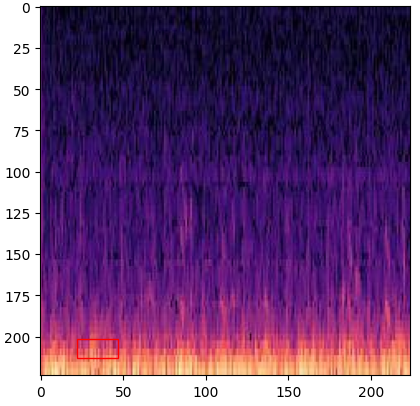

    - 2. 데이터 특성을 활용하는 방법: Crackle과 Wheeze데이터 특성을 이용해서 각각에 맞는 Hz 범위에서 dB or energy값을 np.where을 사용해서 검출한 후에 bbox를 만든다. -> 진행중

    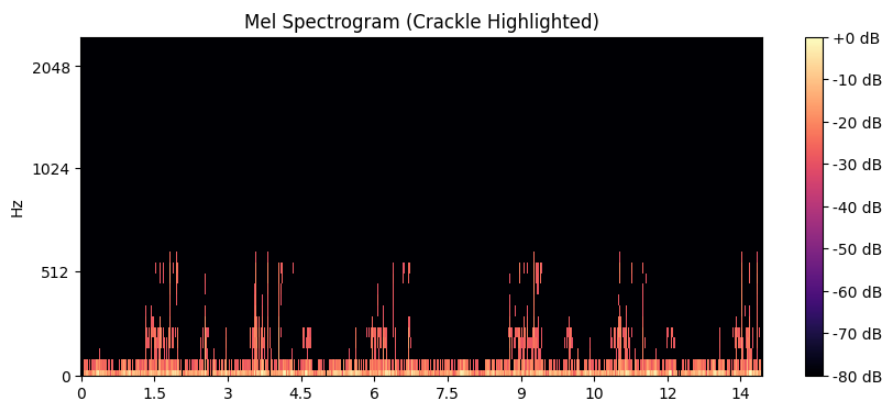

    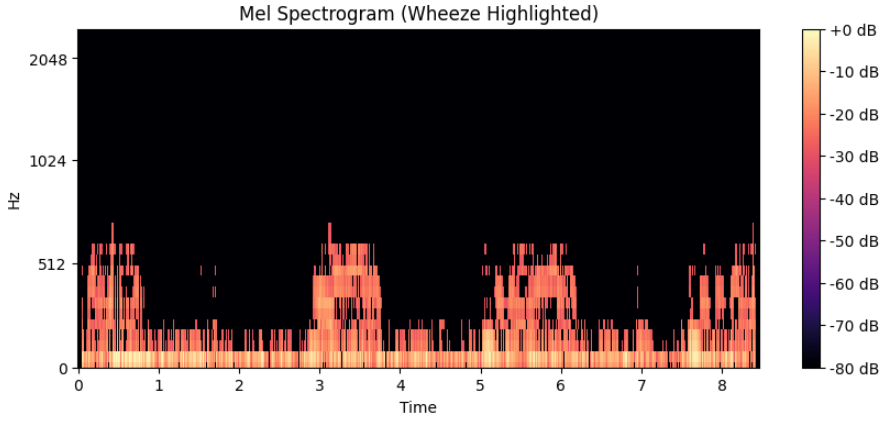

# ICBHI_2017 데이터셋 정보



## Filename Info

1. Patient number (101,102,...,226)

2. Recording index

3. Chest location

      a. Trachea (Tc)

      b. Anterior left (Al)

      c. Anterior right (Ar)

      d. Posterior left (Pl)

      e. Posterior right (Pr)

      f. Lateral left (Ll)

      g. Lateral right (Lr)

4.    Acquisition mode

     a. sequential/single channel (sc),

     b. simultaneous/multichannel (mc)

5.    Recording equipment

     a. AKG C417L Microphone (AKGC417L),

     b. 3M Littmann Classic II SE Stethoscope (LittC2SE),

     c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200),

     d.  WelchAllyn Meditron Master Elite Electronic Stethoscope (Meditron)

# 1. EDA

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

class EdaTool():
  def __init__(self, data_path):
    self.data_path = data_path

  def get_diagnosis_df(self, text_file_path):
    '''
    텍스트 파일을 받아서 진단 데이터 프레임을 return하는 함수

    :param: 진단정보 파일명
    :return: 진단정보 데이터 프레임
    '''
    return pd.read_csv(text_file_path, sep='\t', header=None, names=['patient_id', 'disease'])

  def get_disease_ratio(self, diagnosis_df):
    print (diagnosis_df.disease.value_counts())
    print ('')
    print (diagnosis_df.disease.value_counts(normalize=True) *100)

  def show_diagnosis_countplot(self, diagnosis_df):
    sns.countplot(diagnosis_df.disease)

    plt.show()

  def get_sample_and_cycle(self):
    text_files = glob.iglob(self.data_path + '/*.txt', recursive=True)
    text_files_list = list(text_files)

    dfs = []
    for file in text_files_list:
        content = pd.read_csv(file, names = ["start_time", "end_time", "crackles", "wheezes"], delimiter = "\t")
        patient_number = file.split("_")[3][9:]
        content['patient'] = int(patient_number)
        dfs.append(content)
    samples = pd.concat(dfs)

    print("There are", len(samples), "cycles")
    print("There are", len(text_files_list), "samples")


eda_tool = EdaTool(data_path = '/content/drive/MyDrive/AIFFEL_THON/ICBHI_final_database')

## 진단 dataframe

In [62]:
diagnosis_file_path = '/content/drive/MyDrive/AIFFEL_THON/ICBHI_Challenge/ICBHI_Challenge_diagnosis.txt'
diagnosis_df = eda_tool.get_diagnosis_df(text_file_path = diagnosis_file_path)

In [47]:
diagnosis_df.head()

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


## 질병 비율 확인

In [53]:
eda_tool.get_disease_ratio(diagnosis_df)

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: disease, dtype: int64

COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Pneumonia          4.761905
Bronchiolitis      4.761905
LRTI               1.587302
Asthma             0.793651
Name: disease, dtype: float64


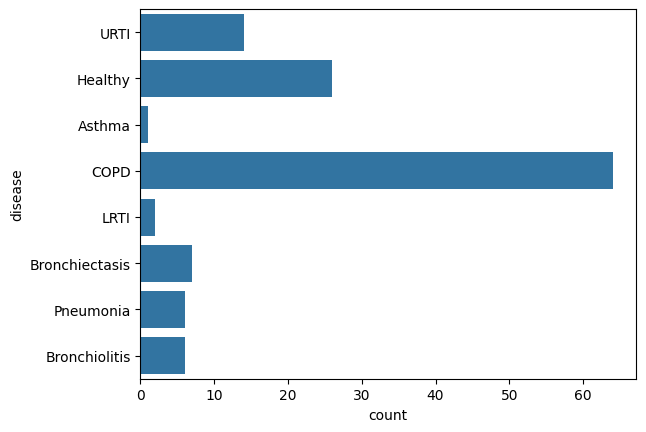

In [59]:
eda_tool.show_diagnosis_countplot(diagnosis_df)

## 호흡데이터 확인

In [61]:
eda_tool.get_sample_and_cycle()

There are 6898 cycles
There are 920 samples


## 호흡데이터 시각화

In [172]:
import librosa
import librosa.display
import numpy as np
from scipy.signal import butter, lfilter
import os

class utils():
    '''
    utils
    '''
    def butter_bandpass(self, lowcut, highcut, fs, order=5):
      nyq = 0.5 * fs
      low = lwcut / nyq
      high = highcut / nyq
      b, a = butter(order, [low, high], btype='band')
      return b, a

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=5):
      b, a = butter_bandpass(lowcut, highcut, fs, order=order)
      y = lfilter(b,a, data)
      return y

    def plot_mel_spectrogram(self, wav_file_path, sample_rate=8000, n_fft=512, hop_length=256, n_mels=32, f_max=2500):
      y, sr = librosa.load(wav_file_path, sr=sample_rate)

      # 수정된 속성을 사용하여 멜 스펙트로그램 계산
      S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=f_max)

      # 멜 스펙트로그램을 디스플레이하기 위한 코드 (선택 사항)
      plt.figure(figsize=(10, 4))
      librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sample_rate, hop_length=hop_length, y_axis='mel', fmax=f_max, x_axis='time')
      plt.colorbar(format='%+2.0f dB')
      plt.title('Mel Spectrogram')
      plt.tight_layout()
      plt.show()

    def play_sound(self, wav_file_path):
      y, sr = librosa.load(wav_file_path, sr=8000)
      return Audio(data=y, rate=sr)

In [173]:
class SampleLoader():
    '''
    샘플 데이터를 불러오는 클래스 mel-spectogram으

    1. audio_load() - Patient number, Chest location, Recording equipment

    2. random_sample_load() - count

    3. text_load()
    '''
    def __init__(self, data_path, sample_rate=8000):
      self.data_path = data_path
      self.sample_rate = sample_rate
      self.desired_length = 8  # 원하는 길이 (이 값은 melspectrogram 함수에 직접 사용되지 않음)
      self.n_mels = 32  # 멜 필터뱅크의 수
      self.nfft = 256  # FFT 윈도우 크기
      self.hop_length = self.nfft // 2  # 프레임 사이의 샘플 수
      self.f_max = 2500  # 최대 주파수 50hz ~ 2000hz 사이의 값
      self.audio_utils = utils() # util class
      self.example_crackle_path = '/content/drive/MyDrive/AIFFEL_THON/TEST_Data/Crackles_pneumoniaO.ogg'
      self.example_wheeze_path = '/content/drive/MyDrive/AIFFEL_THON/TEST_Data/Wheeze2O.ogg'

    def example_crackle(self):

      self.audio_utils.plot_mel_spectrogram(wav_file_path = self.example_crackle_path)

    def example_crackle_sound(self):

      return self.audio_utils.play_sound(wav_file_path = self.example_crackle_path)

    def example_wheeze(self):

      self.audio_utils.plot_mel_spectrogram(wav_file_path = self.example_wheeze_path)

    def example_wheeze_sound(self):

      return self.audio_utils.play_sound(wav_file_path = self.example_wheeze_path)

    def audio_load(self, patient_number=None, chest_location=None, recording_equipment=None):
      # 데이터 디렉토리에서 파일 목록 가져오기
      file_list = os.listdir(self.data_path)

      # 파일명에 해당 문자열이 포함된 파일 찾기
      for file_name in file_list:
          # 선택적 매개변수가 None이 아닌 경우에만 해당 문자열이 파일명에 포함되는지 확인
          if (patient_number is None or patient_number in file_name) and \
            (chest_location is None or chest_location in file_name) and \
            (recording_equipment is None or recording_equipment in file_name) and \
            file_name.endswith('.wav'):
              file_path = os.path.join(self.data_path, file_name)
              print(file_name)

    def find_crackle_wheeze():


In [174]:
sample_loader = SampleLoader(data_path='/content/drive/MyDrive/AIFFEL_THON/ICBHI_final_database', sample_rate=8000)

### Crackle 데이터 시각화

Crackle 데이터 특징

- 체액이나 분비물로 닫혀있던 폐포가 숨을 들이마실 때 열리면서 나는 소리로 비연속적이다. 한국어로 수포음이라고 한다.
  - coarse crackle: 굵은 수포음은 빨대로 물에 공기를 불어넣을 때 부글부글 소리와 비슷하다.
  - fine crackle: 가는 수포음은 머리카락 비비는 소리 또는 찍찍이(벨크로) 테이프를 붙였다 뗐다 하는 소리와 비슷하다.
- Hz: 100Hz~200Hz
- 지속시간: 짧게 여러번 나타난다.


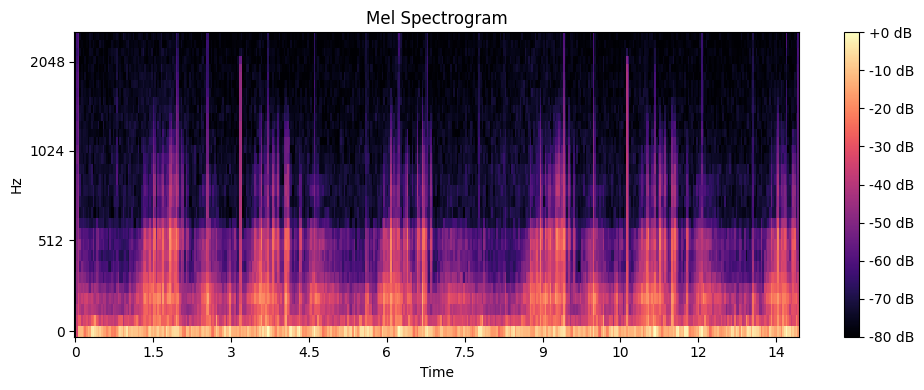

In [175]:
sample_loader.example_crackle()

In [176]:
from IPython.display import Audio

sample_loader.example_crackle_sound()

### Wheeze 데이터 시각화

Wheeze 데이터 특징

- 기도에서 나는 소리로 쌕쌕거리는 소리를 말한다. 한국어로는 천명음이라고 한다.
- 주로 호흡 주기중 숨을 들이마실 때 발생한다. (병에 따라서 다름)
- Hz: 200Hz~1200Hz
- 지속시간: 100ms 이상 비교적 길다.


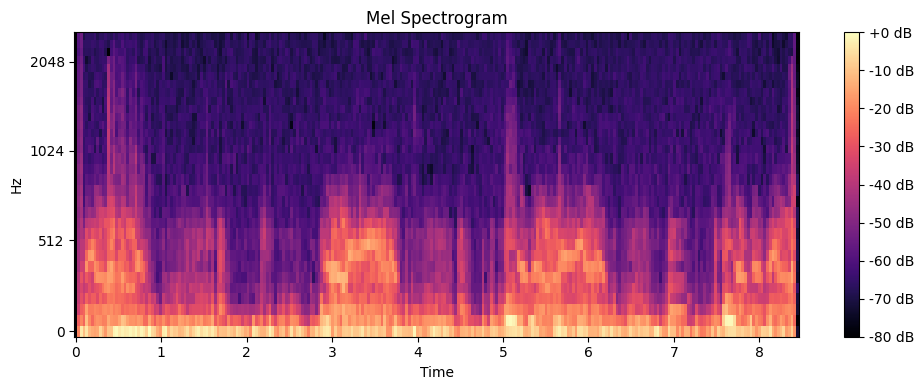

In [177]:
sample_loader.example_wheeze()

In [178]:
sample_loader.example_wheeze_sound()

# 2. Pre Processing

# 3. Split Data

# 4. Feature Extraction

# 5. Model

# 6. Evaluate